In [2]:
import os
from os import path
import xml.etree.ElementTree as ET
import cv2

import numpy as np
import shutil as sh

import matplotlib.pyplot as plt

import yaml

In [7]:
####### ANNOTATIONS in .TXT CREATION ############
#################################################

source = 'coffee_raw'

label_paths = path.join(source, "Etiquetas")
image_paths = path.join(source, "Imagenes")

count_not1024 = 0
total_images = 0

class_to_index = dict()

for label_path in os.listdir(label_paths):
    label_full_path = path.join(label_paths, label_path)
    img_name, _ = label_path.split('.')

    img_full_path = path.join(image_paths, img_name) + ".jpg"
    img = cv2.imread(img_full_path)

    #print(f"before {img.shape}")

    if img.shape[2] != 3:

        print(img_full_path)
        print(img.shape, img_full_path, img)
        #new_img = np.swapaxes(img.copy(), 0,2)#.swapaxes(1,2)
        #print(img.shape)
        assert cv2.imwrite(img_full_path, new_img) 
        img = new_img.copy()
        break

    img_true_height, img_true_width, depth = img.shape
    assert depth == 3, f"depth = {depth}"
    

    xml_tree = ET.parse(label_full_path)
    root = xml_tree.getroot()
    annotations = root.findall("object")

    # Width and Height vary
    img_size = root.find("size")

    img_width = int(img_size.find("width").text)
    img_height = int(img_size.find("height").text)

    # Image size describe in the XML should be the same as true image size (not always the case)
    if img_true_width != img_width or img_true_height != img_true_height :
         print(f"""Width and height of the image and XML info differs :
               True image size: {img_true_width} {img_true_height}
               XML info : {img_width} {img_height}
               for img {label_full_path}""")
        
    img_width = img_true_width
    img_height = img_true_height

    str_full = ""


    # Counting images
    if img_width != 1024 or img_height != 1024:
        count_not1024 += 1
    total_images += 1

    # Reformat each bounding box to one info per line
    for annotation in annotations:

        # Retrieve coordinates
        bndbox = annotation.find("bndbox")
        xmin, ymin = int(bndbox.find("xmin").text), int(bndbox.find("ymin").text)
        xmax, ymax = int(bndbox.find("xmax").text), int(bndbox.find("ymax").text)


        # Convert [rectangle dimensions] to [center and rectangle width and height] in percentage of the total image
        width_x, width_y = xmax - xmin, ymax - ymin
        center_x, center_y = (xmax - xmin) / 2 + xmin, (ymax - ymin) / 2 + ymin

        # Retrieve class
        object_class = annotation.find("name").text

        # Create new index if the class does not exist, allow flexible number of cafe class in training
        ################## NOT AVAILABLE AT THE MOMENT ##########
        #########################################################
        #if object_class in class_to_index:
        #    index = class_to_index[object_class]
        #else:
        #    index = len(class_to_index)
        #    class_to_index[object_class] = index

        # Only one class at the moment
        index = 0

        str_full += " ".join(map(str, [index,
                                        center_x / img_width, center_y / img_height,
                                        width_x / img_width, width_y / img_height]))
        str_full += "\n"

    bbox_str_path = img_name + ".txt"
    bbox_str_path = path.join(image_paths, bbox_str_path)

    with open(bbox_str_path, "w") as f:
        f.write(str_full)
    

    str_full = ""


print(f"Number of images not 1024x1024 format :{count_not1024} / {total_images}")

Width and height of the image and XML info differs :
               True image size: 4128 2322
               XML info : 2322 4128
               for img coffee_raw/Etiquetas/1615379843027.xml
Width and height of the image and XML info differs :
               True image size: 4128 2322
               XML info : 2322 4128
               for img coffee_raw/Etiquetas/1615401570714.xml
Width and height of the image and XML info differs :
               True image size: 1024 1024
               XML info : 0 0
               for img coffee_raw/Etiquetas/1615328632428.xml
Number of images not 1024x1024 format :261 / 438


coffee_raw/Imagenes/1615571175597.jpg (4128, 2322, 3)
(4128, 2322, 3)
3096
coffee_raw/Imagenes/1615572146561.jpg (4128, 2322, 3)
(4128, 2322, 3)
3096
coffee_raw/Imagenes/1615316649209.jpg (1024, 1024, 3)
coffee_raw/Imagenes/1615572436799.jpg (4128, 2322, 3)
(4128, 2322, 3)
3096
coffee_raw/Imagenes/1615316537012.jpg (1024, 1024, 3)
coffee_raw/Imagenes/1615483719758.jpg (1024, 1024, 3)
coffee_raw/Imagenes/1615404283900.jpg (4128, 2322, 3)
(4128, 2322, 3)
3096
coffee_raw/Imagenes/1615404266084.jpg (4128, 2322, 3)
(4128, 2322, 3)
3096
coffee_raw/Imagenes/1615571129570.jpg (4128, 2322, 3)
(4128, 2322, 3)
3096
coffee_raw/Imagenes/1615563796122.jpg (4128, 2322, 3)
(4128, 2322, 3)
3096
coffee_raw/Imagenes/1615402442589.jpg (4128, 2322, 3)
(4128, 2322, 3)
3096
coffee_raw/Imagenes/1615686808023.jpg (1024, 1024, 3)
coffee_raw/Imagenes/1615232420444.jpg (1024, 1024, 3)


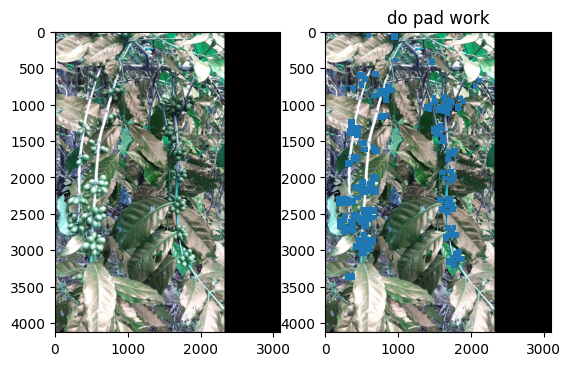

In [5]:
########### SPLIT IMAGES IN SQUARE PARTS #######
################################################

# At the moment, images vary is size (sic.) so we pad them to have the same ratio (3/2)
from utils import pad_image_labels, display_image_and_box_list, display_image_and_box
import os
from os import path
import cv2

new_size = (640,480)

raw_images_dir = "coffee_raw/Imagenes/"

for i, image_path in enumerate(os.listdir(raw_images_dir)):

    if image_path[-3:] == "txt":
        continue
    
    image_full_path = path.join(raw_images_dir, image_path)
    
    current_img = cv2.imread(image_full_path)
    img_shape = current_img.shape

    print(image_full_path, img_shape)

    if img_shape[0] == 1024:
        downsize_img = cv2.resize(current_img, dsize=new_size)
        #cv2.imwrite(image_full_path, downsize_img)

    else:

        
        label_file = open(image_full_path[:-3] + "txt")
        #display_image_and_box(current_img, label_file, "oldbbox")

        #current_img = cv2.resize(current_img, dsize=new_size)
        padded_image, bbox_list = pad_image_labels(current_img, label_file)
        

    if i > 25:
        display_image_and_box_list(padded_image, bbox_list, "do pad work")
        break




In [1]:
#### SPLIT TRAIN VAL FOR ALL IMAGES ####
########################################

# Don't ignore images that are not 1024x1024
new_size = (640,640)

raw_images_dir = "coffee_raw/Imagenes/"

proportion_trainval = 0.80
n_train = int(count_1024 * proportion_trainval)

count_copied_image = 0

train_dir = "datasets/train"
val_dir = "datasets/val"

if not os.path.exists("datasets"):
    os.mkdir("datasets")
    os.mkdir(train_dir)
    os.mkdir(val_dir)

    os.mkdir(path.join(train_dir, "images"))
    os.mkdir(path.join(train_dir, "labels"))

    os.mkdir(path.join(val_dir, "images"))
    os.mkdir(path.join(val_dir, "labels"))



for image_path in os.listdir(raw_images_dir):
    
    # Ignore .txt
    if image_path[-3:] == "txt":
        continue

    image_full_path = path.join(raw_images_dir, image_path)

    current_img = cv2.imread(image_full_path)
    img_shape = current_img.shape

    #print(img_shape)
    width = img_shape[0]

    # Ignore images greater than 1024
    if width != 640:
        raise NotImplementedError("Images should be 640x640")

    
    if count_copied_image < n_train:
        image_new_full_path = path.join(train_dir, "images", image_path)
        label_new_full_path = path.join(train_dir, "labels", image_path)

    else:
        image_new_full_path = path.join(val_dir, "images", image_path)
        label_new_full_path = path.join(val_dir, "labels", image_path)



    # Copy image AND label txt to path
    sh.copy(image_full_path, image_new_full_path)
    sh.copy(image_full_path[:-3]+"txt", label_new_full_path[:-3]+"txt")

    count_copied_image += 1

print("Finished Splitting")


NameError: name 'count_1024' is not defined

In [9]:
wheet_yaml = dict(
    train ='train',
    val ='val',
    nc =1,
    names =["cafe verde"]
)

with open('coffee.yaml', 'w') as outfile:
    yaml.dump(wheet_yaml, outfile, default_flow_style=True)

In [17]:
a = [[1,2],[2,3],[0,0]]
a.sort(key=lambda x:x[0])

In [19]:
######################## NOT USED #################

In [ ]:
def split_image(current_img, label_file):
    
    true_width, true_height = current_img.shape[0], current_img.shape[1]

    kept_bbox_count = 0
    bboxs = []

    for bbox_str in label_file.readlines():
        object_class, center_x, center_y, width_x, width_y = tuple(map(float, bbox_str.split(" ")))
        
        width_x *= true_width
        width_y *= true_height
        center_x *= true_width
        center_y *= true_height
        corner_x = center_x - width_x // 2
        corner_y = center_y - width_y // 2

        bboxs.append([corner_x, corner_y, width_x, width_y])

    if true_width > true_height :

        #(4128, 2322, 3) example
        need_to_reduce = true_height - true_width // 2

        if need_to_reduce < 0:
            assert NotImplementedError("Warning, image not dealt with")

        bboxs.sort(key=lambda x:x[1])
        print(bboxs)

        bboxs = 


        image1 = current_img[:width//2, :]
        image2 = current_img[width//2:, :]
    else:
        image1 = current_img[:, :height//2]
        image2 = current_img[:, height//2:]
        

    #fig, (ax1, ax2) = plt.subplots(1, 2)
    #ax1.imshow(image1)
    #ax2.imshow(image2)